In [1]:
import numpy as np
import pandas as pd
import re
import string

df_dev = pd.read_csv('development.csv')
df_eval = pd.read_csv('evaluation.csv')

# Data Exploration

df_dev is composed of 224994 rows.
There are 130157 positive sentiments.
There are 94837 negative sentiments.
df_eval is composed of 74999 rows.
Missing values for each column:
sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64
Number of unique elements for each column:
sentiment         2
ids          224716
date         189779
flag              1
user          10647
text         223106
dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

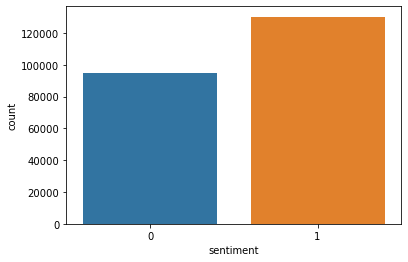

In [2]:
#Overview of the problem

print(f"df_dev is composed of {len(df_dev)} rows.")
print(f"There are {(df_dev['sentiment']==1).sum()} positive sentiments.")
print(f"There are {(df_dev['sentiment']==0).sum()} negative sentiments.")
print(f"df_eval is composed of {len(df_eval)} rows.")

#We observe that there are no missing values in df_dev
print("Missing values for each column:")
print(df_dev.isna().sum())

#Cardinality of each column
print("Number of unique elements for each column:")
print(df_dev.nunique())

#Plot 'sentiment' distribution
import seaborn as sns
sns.countplot(x='sentiment', data=df_dev)

# Pre-processing 

In [3]:
#Delete tweets with same 'ids' (only in the training dataset)
df_dev = df_dev.drop_duplicates(subset=['ids'])

#Drop 'flag' 
df_dev = df_dev.drop(columns=['flag'])

In [4]:
#Functions to clean the text

def clean_text(text):
    # Makes text lowercase, removes text in square brackets, links, RTs, punctuation
    # and words containing numbers.
    text = re.sub('RT @\w+:',"",text)
    text = re.sub("(@[A-Za-z0–9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [5]:
#We create our own list of stopwords
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers','hes', 'herself', 'him', 'himself', 'his', 'how', 'i','im', 'if', 'in',
             'into','is','isnt', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me','mine' 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own','r', 're','s', 
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through','till', 'to', 'too','u','ur','us','under', 'until', 'up', 've', 'very', 'was','wasnt',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y','ya', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [6]:
def tokenization(text):
    return re.split('\W+', text)

def reduce_length_words(text):
    return [re.sub(r'(.)\1+', r'\1\1', word) for word in text ]

def remove_stopword(text, stopwordlist):
    return [word for word in text if word not in stopwordlist]

import nltk
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

def delete_empty_spaces(l):
    return [x for x in l if ((x.isspace() == False) and (x != '')) ]

In [7]:
#Apply all the above functions to clean and transform 'text'
def pre_processing_text(df):
    #clean text
    df['text']=df['text'].apply(lambda x:clean_text(x))
    #tokenize
    df['text']=df['text'].apply(tokenization)
    #reduce length double letters
    df['text']=df['text'].apply(reduce_length_words)
    #remove stopwords
    df['text']=df['text'].apply(lambda x:remove_stopword(x, stopwordlist))
    #stemming
    df['text']=df['text'].apply(stemming)
    #delete empty spaces
    df['text']=df['text'].apply(delete_empty_spaces)
    return df

In [8]:
#Pre-process df_dev
df_dev = pre_processing_text(df_dev)

In [9]:
#Split df_dev in X_train and X_valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_dev.drop(columns=['sentiment']), df_dev['sentiment'], test_size=0.2, random_state=42)

In [10]:
#Delete the rows of X_train that are reduced to only an empty space
def empty_spaces_check(l):
    if all('' == s or s.isspace() for s in l):
        return False
    else:
        return True

rows_not_only_spaces = X_train['text'].apply(empty_spaces_check)
X_train = X_train[rows_not_only_spaces]
y_train = y_train[rows_not_only_spaces]

In [11]:
#One-Hot encoding on 'user'
X_train_user_dummies = pd.get_dummies(X_train['user'])

#do the same for X_valid, considering that we only use user that are 
#present in X_train
X_valid_user_dummies = pd.get_dummies(X_valid['user'])
missing_cols = [col for col in X_train_user_dummies.columns if col not in X_valid_user_dummies.columns]
for col in missing_cols:
    X_valid_user_dummies[col] = 0
X_valid_user_dummies = X_valid_user_dummies[X_train_user_dummies.columns]

In [12]:
#Take 10000 most common words
from collections import Counter
top = Counter([item for sublist in X_train['text'] for item in sublist])
temp = pd.DataFrame(top.most_common(10000))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
most_frequent_words = list(temp.Common_words.values)

In [13]:
#Transform 'text' from list of tokens to string, in order to make it
#usable by Tf-Idf
def from_list_to_string(text):
    string=''
    for word in text:
        string=string+word+' '
    return string

X_train['string_text'] = X_train['text'].apply(from_list_to_string)
X_valid['string_text'] = X_valid['text'].apply(from_list_to_string)

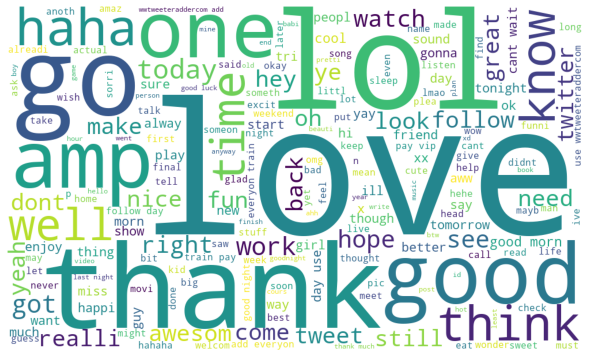

In [16]:
#Word cloud for positive frequent words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_dev['string_text'] = df_dev['text'].apply(from_list_to_string)
positive_df = df_dev.loc[df_dev['sentiment']==1]
words_positive=' '.join(list(positive_df['string_text']))

wordcloud = WordCloud(width = 1000, height = 600,
                background_color ='white',
                min_font_size = 10).generate(words_positive)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

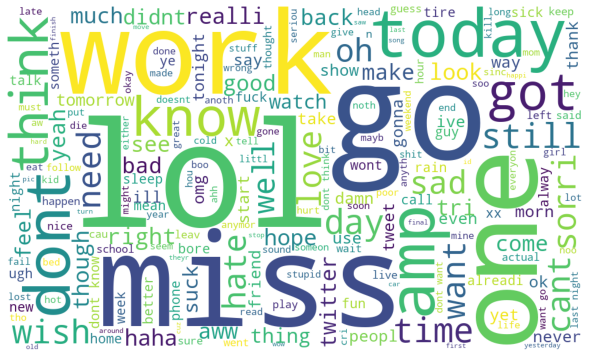

In [17]:
#Word cloud for negative frequent words

df_dev['string_text'] = df_dev['text'].apply(from_list_to_string)
negative_df = df_dev.loc[df_dev['sentiment']==0]
words_negative=' '.join(list(negative_df['string_text']))

wordcloud = WordCloud(width = 1000, height = 600,
                background_color ='white',
                min_font_size = 10).generate(words_negative)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [18]:
#Now we work on the 'date' variable:
#we create a variable 'month' with the date month
#and a variable 'hour' with the date hour
def month(row):
    return str(row).split(' ')[1]

def hour(row):
    return int(str(row).split(' ')[3].split(':')[0])

X_train['month'] = X_train['date'].apply(month)
print(f"Different months of pubblication of tweets: {X_train['month'].unique()}")

#Only 3 months: April, May, June; We drop it
X_train = X_train.drop(columns=['month'])

#Therefore we work on the 'hour' variable
X_train['hour'] = X_train['date'].apply(hour)
X_valid['hour'] = X_valid['date'].apply(hour)

Different months of pubblication of tweets: ['Jun' 'May' 'Apr']


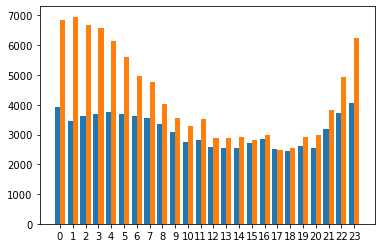

In [19]:
#Plot the distribution of positive/negative sentiment per hour
import numpy as np
import matplotlib.pyplot as plt
hours = list(range(0,24)) 
positive_count = [X_train[(X_train['hour']==hour) & (y_train==1)].count()['ids'] for hour in hours]
negative_count = [X_train[(X_train['hour']==hour) & (y_train==0)].count()['ids'] for hour in hours]
def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
    plt.xticks(_X, X)
subcategorybar(hours, [negative_count, positive_count])
plt.show()

In [20]:
#One-Hot Encoding of 'hours'
X_train_hour_dummies = pd.get_dummies(X_train['hour'])

X_valid_hour_dummies = pd.get_dummies(X_valid['hour'])
missing_cols = [col for col in X_train_hour_dummies.columns if col not in X_valid_hour_dummies.columns]
for col in missing_cols:
    X_valid_hour_dummies[col] = 0
X_valid_hour_dummies = X_valid_hour_dummies[X_train_hour_dummies.columns]

In [21]:
#TF-idf of 'Text'
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer(vocabulary=most_frequent_words)
tf_x_train = vectorizer.fit_transform(X_train['string_text'])
tf_x_valid = vectorizer.transform(X_valid['string_text'])

In [22]:
#We create sparse matrices for the One-Hot-Encodings and merge
#them together
import scipy
X_train_user_sparse = scipy.sparse.csr_matrix(X_train_user_dummies)
X_valid_user_sparse = scipy.sparse.csr_matrix(X_valid_user_dummies)

X_train_hour_sparse = scipy.sparse.csr_matrix(X_train_hour_dummies)
X_valid_hour_sparse = scipy.sparse.csr_matrix(X_valid_hour_dummies)

X_train_sparse = scipy.sparse.hstack((tf_x_train, X_train_user_sparse, X_train_hour_sparse))
X_valid_sparse = scipy.sparse.hstack((tf_x_valid, X_valid_user_sparse, X_valid_hour_sparse))

# Grid-search for LinearSVC

In [ ]:
#Grid-search for linearSVC()
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'loss' : ['hinge', 'squared_hinge'],
    'dual' : [False, True],
    'tol' : [0.01, 0.001, 0.0001, 0.00001],
    'max_iter' : list(range(100,1200,100)),
    'fit_intercept' : [False, True]
}
clf_search = GridSearchCV(clf, param_grid = clf_param_grid, refit = True, verbose = 3, cv = 5, scoring = 'f1_macro')

#Fitting the model for grid search 
clf_search.fit(X_train_sparse, y_train)
clf_search.best_params_
#Summarize
print('Mean f1-score: %.3f' % clf_search.best_score_)
print('Config: %s' % clf_search.best_params_)

In [23]:
#linear SVC
from sklearn.svm import LinearSVC
clf = LinearSVC(C=0.1, dual=False, fit_intercept=True, loss='squared_hinge', max_iter=100, penalty='l2', tol=0.01)
clf.fit(X_train_sparse, y_train)
y_pred=clf.predict(X_valid_sparse)
from sklearn.metrics import f1_score
print("f1-score:")
print(f1_score(y_pred, y_valid, average='macro'))

f1-score:
0.8151675181526279


# Grid-search for Logistic Regression

In [ ]:
#Grid search for Logistic Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LRparam_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,1200,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
LR_search = GridSearchCV(LR, param_grid = LRparam_grid, refit = True, verbose = 3, cv = 5, scoring = 'f1_macro')

#Fitting the model for grid search 
LR_search.fit(X_train_sparse, y_train)
LR_search.best_params_
#Summarize
print('Mean f1-score: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

In [24]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1, max_iter=300, penalty='l2', solver='newton-cg')
lr.fit(X_train_sparse, y_train)
y_pred=lr.predict(X_valid_sparse)
from sklearn.metrics import f1_score
print("f1-score")
print(f1_score(y_pred, y_valid, average='macro'))

f1-score
0.815357973175434


# Running the model on the evaluation dataset


In [25]:
#We repeat the same operations done on X_train on the entire df_dev
#and operations done on X_valid on df_eval

#Delete 'flag' from df_eval and do pre-processing on 'text'
df_eval = df_eval.drop(columns=['flag'])
df_eval = pre_processing_text(df_eval)

#Remove lines that are reduced to an empty space
rows_not_only_spaces = df_dev['text'].apply(empty_spaces_check)
df_dev = df_dev[rows_not_only_spaces]

#One-hot encoding on 'user'
df_dev_user_dummies = pd.get_dummies(df_dev['user'])
df_eval_user_dummies = pd.get_dummies(df_eval['user'])
missing_cols = [col for col in df_dev_user_dummies.columns if col not in df_eval_user_dummies.columns]
for col in missing_cols:
    df_eval_user_dummies[col] = 0
df_eval_user_dummies = df_eval_user_dummies[df_dev_user_dummies.columns]

#Take 10000 most common words
from collections import Counter
top = Counter([item for sublist in df_dev['text'] for item in sublist])
temp = pd.DataFrame(top.most_common(10000))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
most_frequent_words = list(temp.Common_words.values)

#Transform 'text' from list to string to do Tf-Idf
df_dev['string_text'] = df_dev['text'].apply(from_list_to_string)
df_eval['string_text'] = df_eval['text'].apply(from_list_to_string)

#Extract hour from date
df_dev['hour'] = df_dev['date'].apply(hour)
df_eval['hour'] = df_eval['date'].apply(hour)

#One-hot encoding on hour
df_dev_hour_dummies = pd.get_dummies(df_dev['hour'])

df_eval_hour_dummies = pd.get_dummies(df_eval['hour'])
missing_cols = [col for col in df_dev_hour_dummies.columns if col not in df_eval_hour_dummies.columns]
for col in missing_cols:
    df_eval_hour_dummies[col] = 0
df_eval_hour_dummies = df_eval_hour_dummies[df_dev_hour_dummies.columns]

#Tf-idf on 'text'
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer(vocabulary=most_frequent_words)
tf_dev = vectorizer.fit_transform(df_dev['string_text'])
tf_eval = vectorizer.transform(df_eval['string_text'])

#Transform in sparse matrices and merge them
import scipy
df_dev_user_sparse = scipy.sparse.csr_matrix(df_dev_user_dummies)
df_eval_user_sparse = scipy.sparse.csr_matrix(df_eval_user_dummies)

df_dev_hour_sparse = scipy.sparse.csr_matrix(df_dev_hour_dummies)
df_eval_hour_sparse = scipy.sparse.csr_matrix(df_eval_hour_dummies)

df_dev_sparse = scipy.sparse.hstack((tf_dev, df_dev_user_sparse, df_dev_hour_sparse))
df_eval_sparse = scipy.sparse.hstack((tf_eval, df_eval_user_sparse, df_eval_hour_sparse))

In [26]:
#linear SVC
from sklearn.svm import LinearSVC
clf = LinearSVC(C=0.1, dual=False, fit_intercept=True, loss='squared_hinge', max_iter=100, penalty='l2', tol=0.01)
clf.fit(df_dev_sparse, df_dev['sentiment'])
y_pred=clf.predict(df_eval_sparse)

In [27]:
pd.DataFrame(y_pred, index = df_eval.index).to_csv("svc_solution.csv", index_label = "Id", header = ["Predicted"])

In [28]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1, max_iter=300, penalty='l2', solver='newton-cg')
lr.fit(df_dev_sparse, df_dev['sentiment'])
y_pred=lr.predict(df_eval_sparse)

In [29]:
pd.DataFrame(y_pred, index = df_eval.index).to_csv("lr_solution.csv", index_label = "Id", header = ["Predicted"])